In [75]:
%load_ext autoreload
%autoreload 2

import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from albumentations import *
from torchvision import transforms
from torch.utils.data import DataLoader
from glob import glob
import segmentation_models_pytorch as smp

import torch.nn as nn 
import torch.nn.functional as F
from tqdm import tqdm 

import wandb
import logging
from tqdm import tqdm

# load dataset 
import RS_dataset
import RS_utils
import RS_models

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [76]:
#-- data
img_path = "/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/01.Models/04.SAM_fine/0.data/01.512_imgs"
mask_path = "/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/01.Models/04.SAM_fine/0.data/02.512_masks"

img_path_ship  = np.array(sorted(glob(os.path.join(img_path, "*.png"))) )
mask_path_ship = np.array(sorted(glob(os.path.join(mask_path, "*.png"))) )

aa = np.load("/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/05.Training/Segmentation/03.data_list/512_ships.npy")

selected_paths_img = img_path_ship[aa]
selected_paths_mask  = mask_path_ship[aa]

#-- category 
ISAID_CLASSES_SHIP = (
    'background','ship','harbor' 
    )
ISAID_PALETTE_SHIP = {
    0: (0, 0, 0), 
    1: (0, 0, 63), 
    2: (0, 100, 155)}

In [77]:
# dataset = RS_dataset.Seg_RS_dataset_edge(img_dir=selected_paths_img, mask_dir=selected_paths_mask, image_resize = None, phase="train",palette=ISAID_PALETTE_SHIP )

#-- dataset
dataset = RS_dataset.Seg_RS_dataset_edge_v1(img_dir=selected_paths_img, mask_dir=selected_paths_mask, image_resize = None, phase="train",palette=ISAID_PALETTE_SHIP,gaussian=True,mask_onehot=True,softmax=True )


In [78]:
mask, edge = dataset.__getitem__(np.random.randint(0,400))

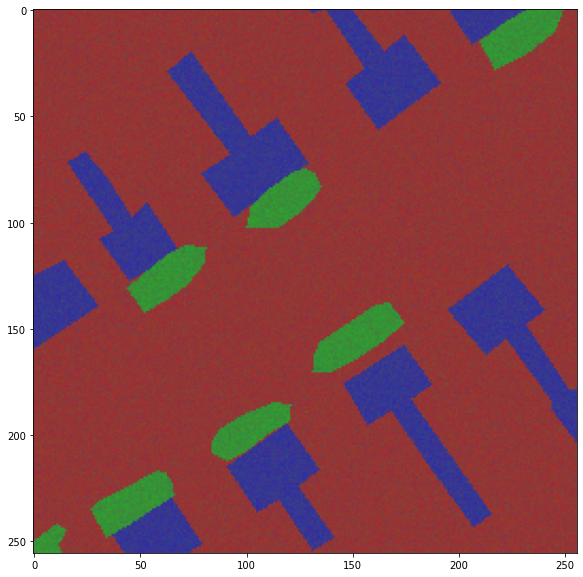

In [79]:
RS_utils.torch_display(mask)

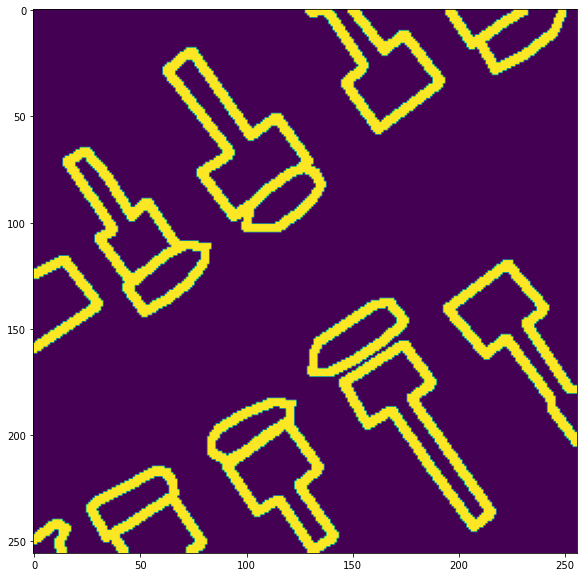

In [80]:
edge = edge.squeeze(0)
RS_utils.torch_display_mask(edge)

In [81]:
aa = "./02.ckpts"

w_path = sorted(glob(os.path.join(aa, "*.pt")))[-1]
print(w_path)
weights_ = torch.load(w_path, map_location=torch.device('cpu'))

model = RS_models.Edge_Net(input_channel=3)
model.load_state_dict(weights_)
model = model.eval()

print(mask.shape)
mask = mask.unsqueeze(0)
pred = model(mask)
pred = pred.detach().cpu()

./02.ckpts/ver_62_EDGE_EDGE_NET_epoch_81_iteration_6081318.pt
torch.Size([3, 256, 256])


torch.Size([1, 256, 256])


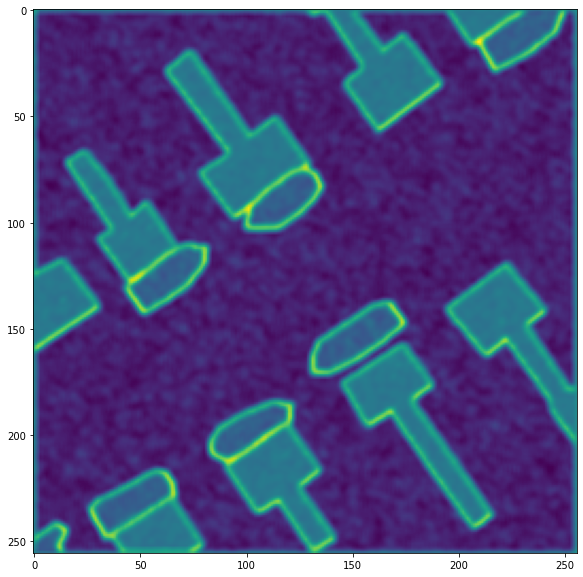

In [82]:
pred= pred.squeeze(0)
print(pred.shape)
RS_utils.torch_display(pred)

In [83]:
torch.mean(pred)

tensor(-3.6155)

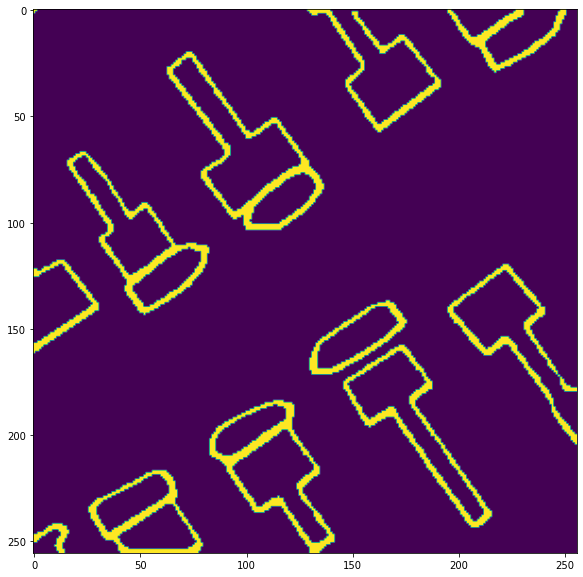

In [84]:
part = pred.clone()
#map = part > 1
map = torch.sigmoid(part)
map = map > 0.5
#print(torch.mean(map))
RS_utils.torch_display(map)